

```
`# This is formatted as code`
```

# Time Series Analysis of Stock Indices

## 1. Load Data

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

In [21]:
df1=pd.read_csv('stockIndices - nifty50.csv')
df2=pd.read_csv('stockIndices - sensex.csv')
df3=pd.read_csv('stockIndices - niftybank.csv')


## 2. Preprocessing
Combine dataframes, set date as index and remove null rows.

In [22]:
for df in (df1, df2, df3):
  df.set_index("Date", inplace=True)
  df.index = pd.to_datetime(df.index)

In [23]:
df=pd.DataFrame({"Nifty":[],"Sensex":[],"NiftyBank":[]})
symbols=["Nifty","Sensex","NiftyBank"]
df.Nifty=df1.Close
df.Sensex=df2.Close
df.NiftyBank=df3.Close
df=df.dropna()

In [24]:
df.head()


,Nifty,Sensex,NiftyBank
Date,,,
2006-11-13 15:30:00,3858.75,13399.0,5801.35
2006-11-16 15:30:00,3876.85,13505.9,6175.05
2006-11-17 15:30:00,3852.80,13429.5,6119.65
2006-11-20 15:30:00,3856.15,13430.7,6006.60
2006-11-21 15:30:00,3918.25,13616.8,6085.50


##3. Visualise Time series

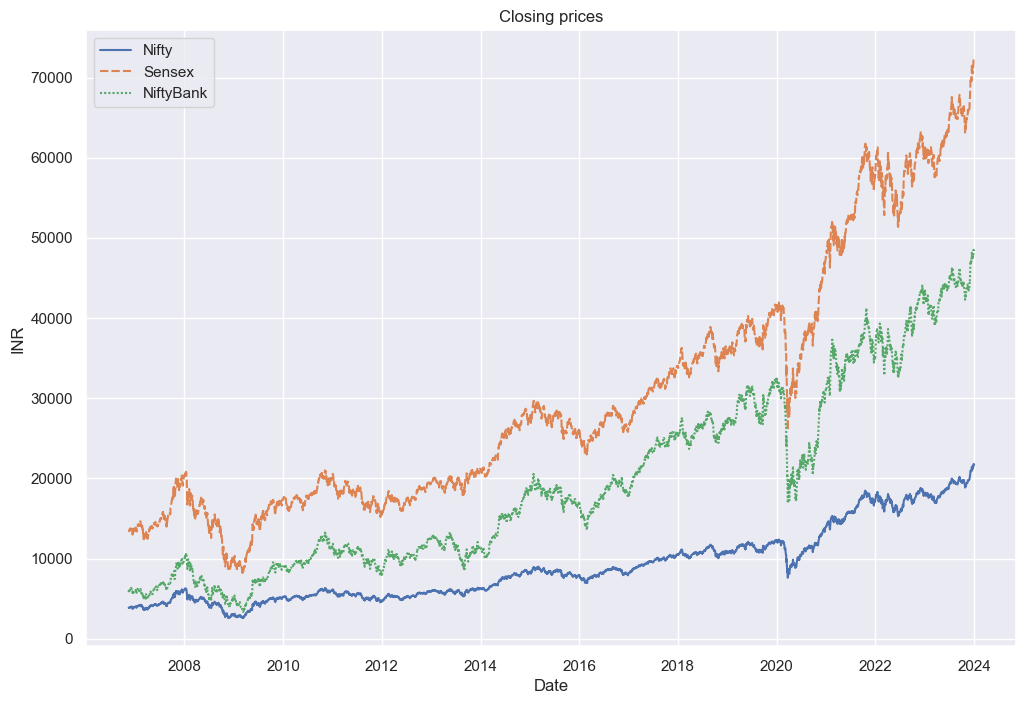

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# yearlyData= closingPrices.loc[(closingPrices.index.year == 2016)  ]
plt.figure(figsize=(12,8))
sns.set_theme(style="darkgrid")
sns.lineplot(data=df)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('INR')
plt.title('Closing prices')
plt.show()

We notice that the series is not stationary and has an upward increasing trend. This can also be seen on performing an Augmented dickey fuller test. We need to detrend it before fitting.

##4. ADF Test on original data

In [26]:
from statsmodels.tsa.stattools import adfuller

for i in symbols:
  print([i])
  result = adfuller(df[i].dropna(), autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Not-Stationary")
  print("\n")


['Nifty']
ADF Statistic: 1.127160
p-value: 0.995442
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['Sensex']
ADF Statistic: 1.134283
p-value: 0.995499
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary


['NiftyBank']
ADF Statistic: 0.259582
p-value: 0.975412
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Failed to reject Null Hypothesis. So, Time Series is Not-Stationary




Since the test statstics value =1.9 > critical values and p-value > 0.05(for 5% significance level), null hypothesis cannot be rejected. Series in non-linear.
We now need to remove any trend or seasonal components before further analysis.

##5. Seasonal decomposition
Splitting series into trend, seasonal and residual components to get an idea of periodicity.

<Figure size 640x480 with 0 Axes>

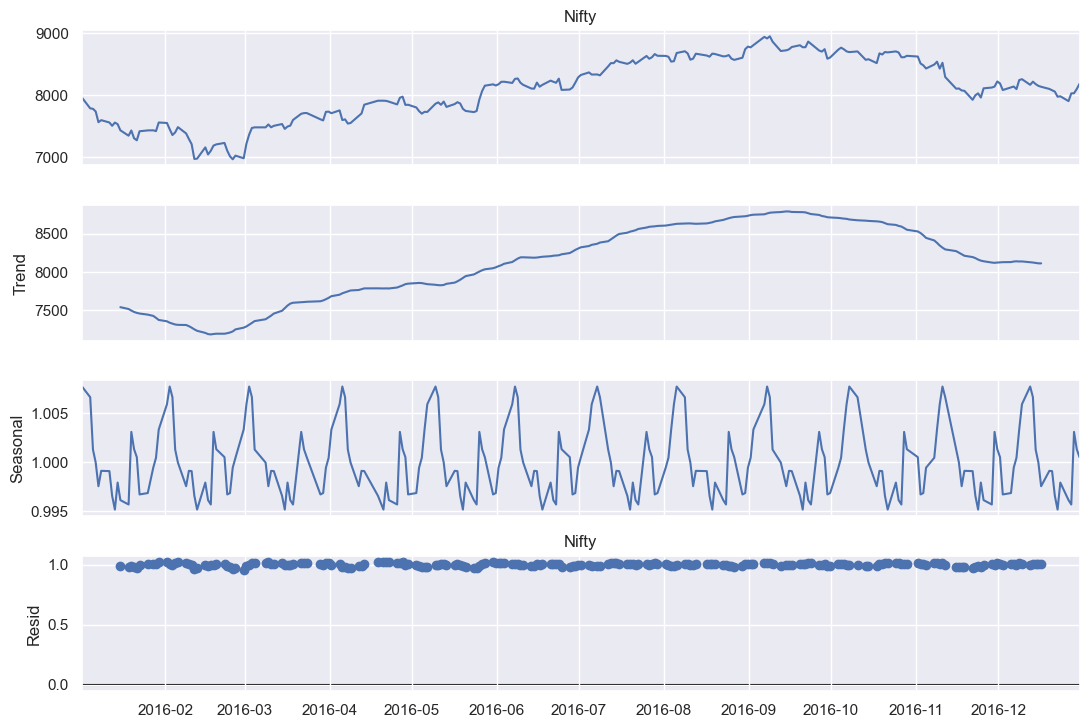

<Figure size 640x480 with 0 Axes>

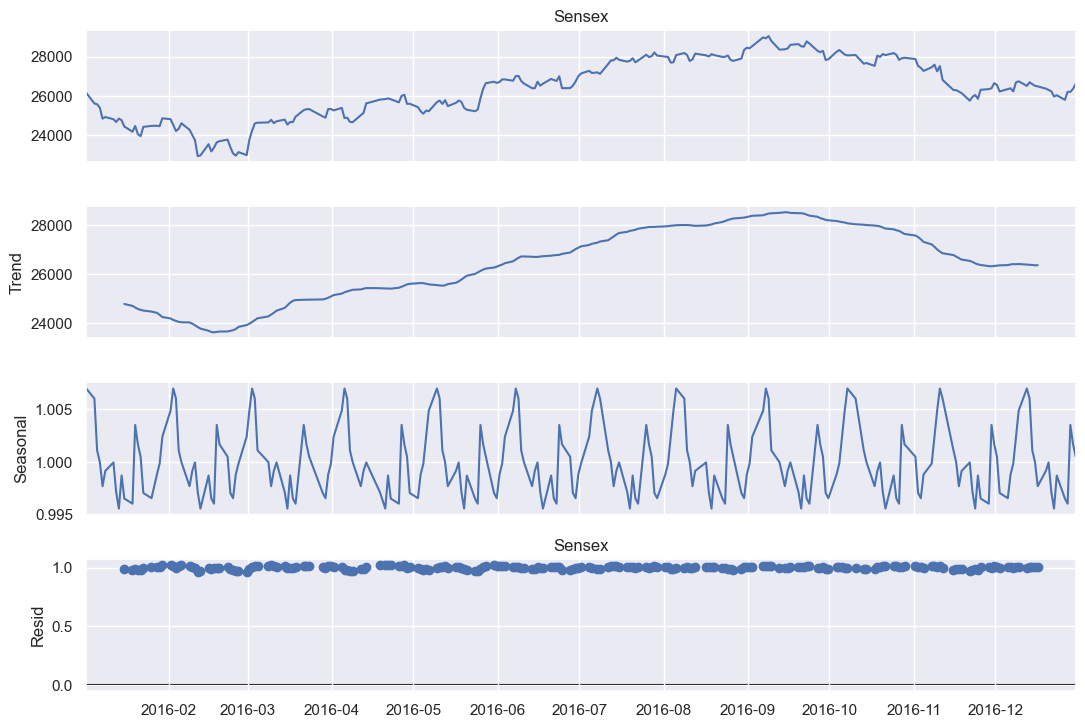

<Figure size 640x480 with 0 Axes>

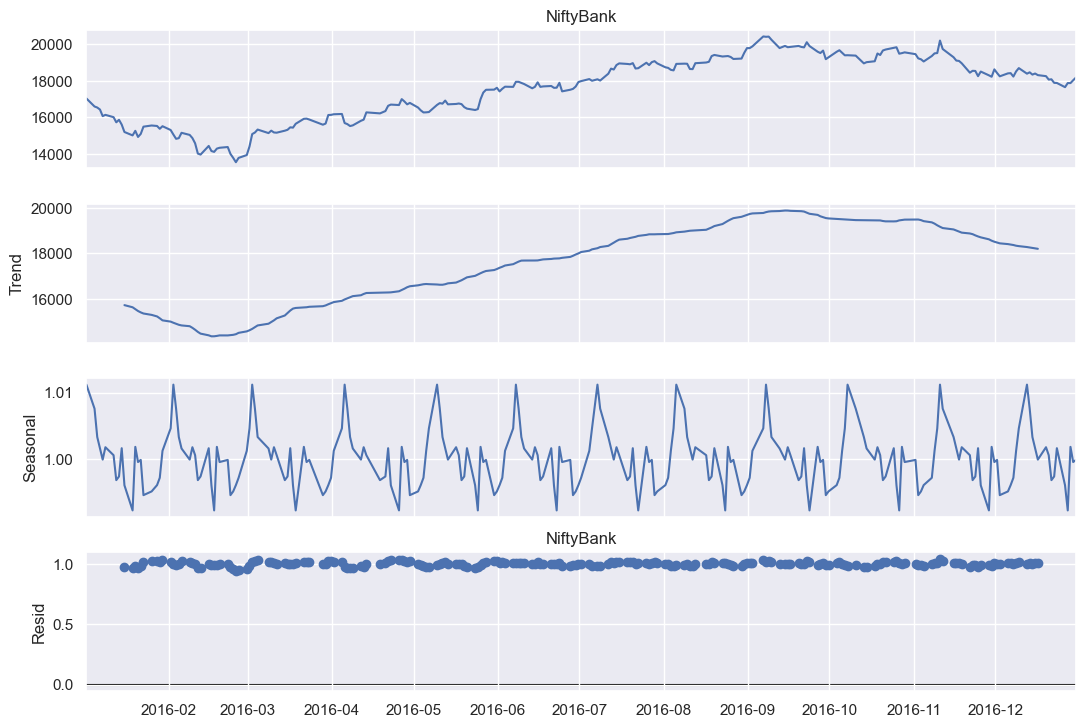

In [27]:
from statsmodels.tsa.seasonal import STL,seasonal_decompose

for i in symbols[0:]:
    result = seasonal_decompose(df[i].loc[df.index.year==2016].dropna(), model='multiplicative', period=21)
    fig = plt.figure()
    fig = result.plot()
    plt.title(i)
    fig.set_size_inches(12, 8)
plt.show()
# yearlyData= closingPrices.loc[(closingPrices.index.year == 2004)]

# # result=seasonal_decompose(yearlyData, model='additive',period=4)
# # fig=plt.figure()
# # fig=result.plot()
# # fig.set_size_inches(16,9)
# stl=STL(yearlyData,21,seasonal=13)
# res=stl.fit()
# fig=res.plot()
# fig.set_size_inches(16,9)
# plt.show()


Looking at data from a year (2016) for better visualisation, we can decompose the series with a period of 21 samples(30 days since weekends are not in the dataset) and notice significant monthly seasonality.
Thus, we will have to take a SARIMA model.
Lets try conventional first differnecing for stationarity method before SARIMA approach.

##6. Plotting ACF and PACF of original and differenced series

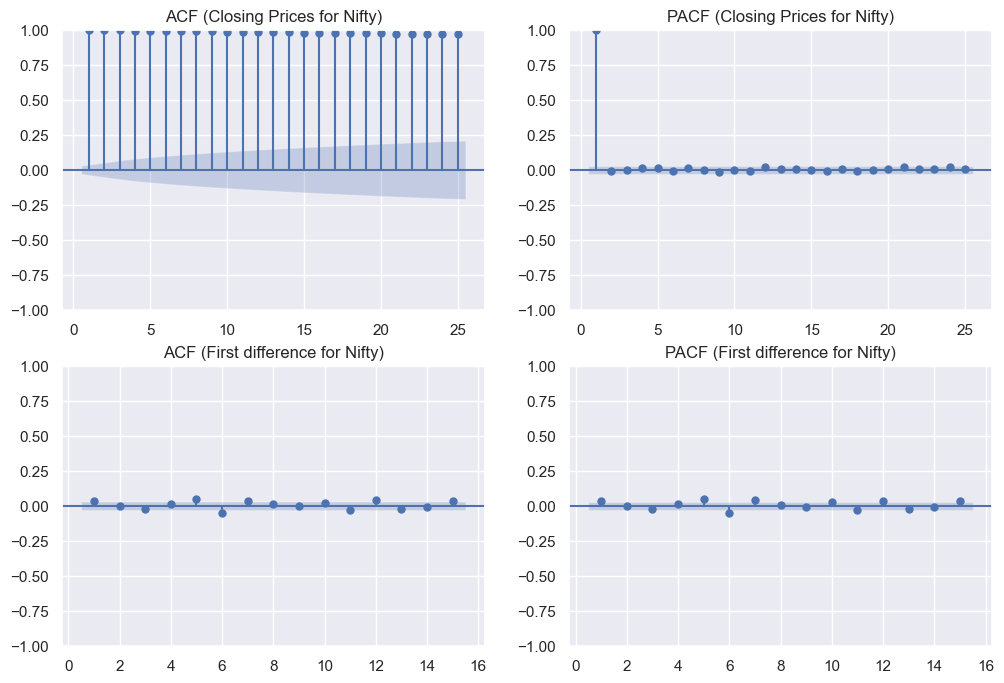

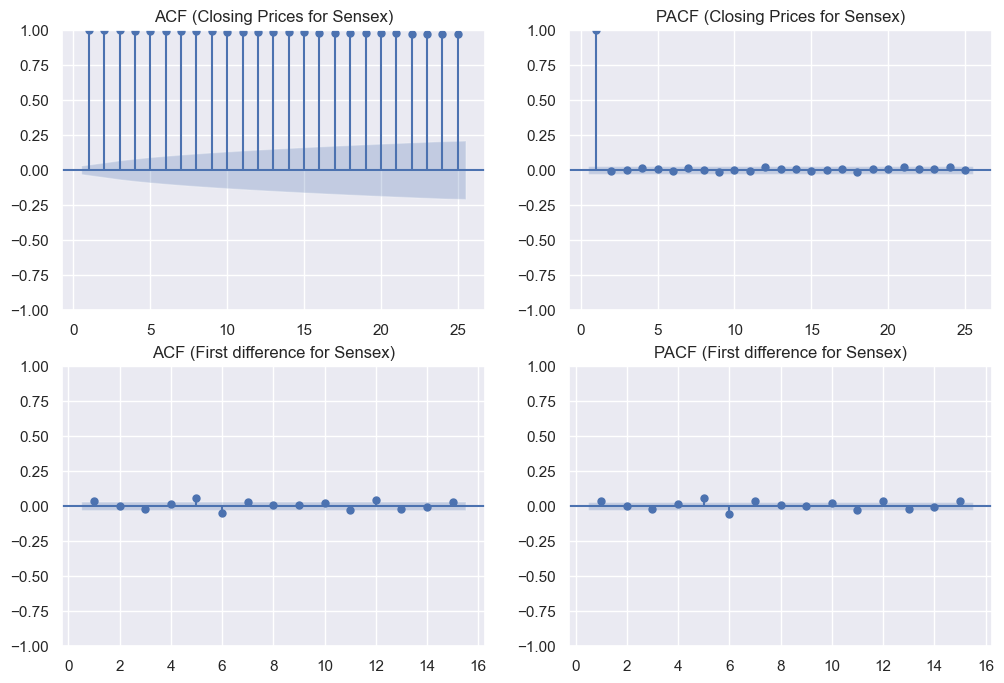

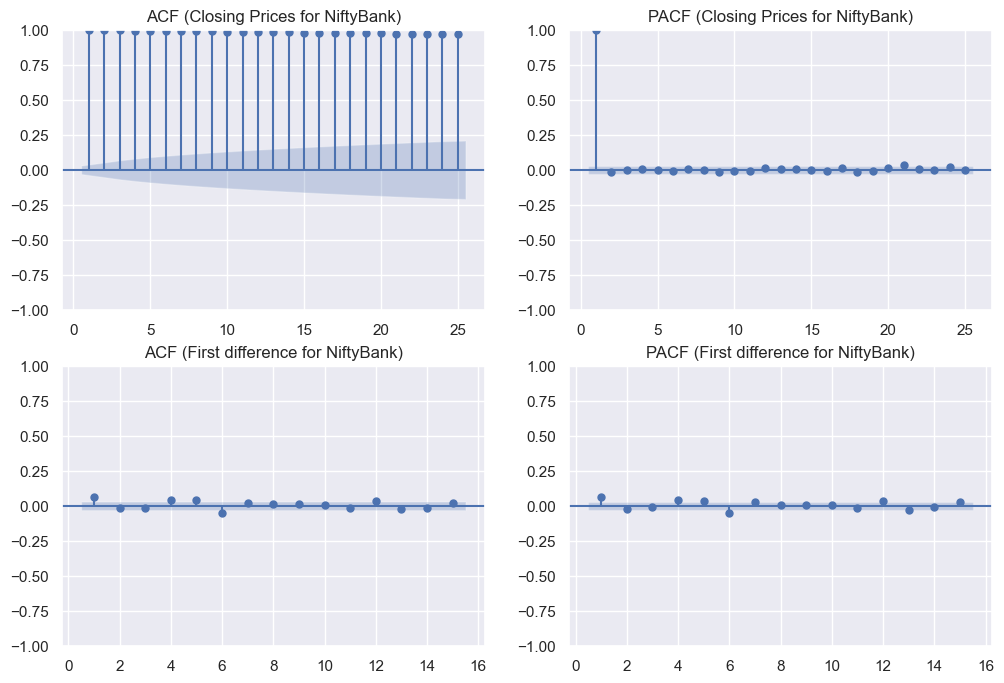

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

diff_df=pd.DataFrame()
for i in symbols:
  diff_df[i]=df[i].dropna().diff()
  # Plot ACF and PACF for the original series
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 2, 1)
  plot_acf(df[i].dropna(), lags=25, ax=plt.gca(), zero=False)
  plt.title(f'ACF (Closing Prices for {i})')

  plt.subplot(2, 2, 2)
  plot_pacf(df[i].dropna(), lags=25, ax=plt.gca(), zero=False)
  plt.title(f'PACF (Closing Prices for {i})')

  # Plot ACF and PACF for the differenced series
  plt.subplot(2, 2, 3)
  plot_acf(diff_df[i].dropna(), lags=15, ax=plt.gca(), zero=False)
  plt.title(f'ACF (First difference for {i})')

  plt.subplot(2, 2, 4)
  plot_pacf(diff_df[i].dropna(), lags=15, ax=plt.gca(), zero=False)
  plt.title(f'PACF (First difference for {i})')

  plt.show()

ACF (Autocorrelation Function) Analysis:

ACF(Closing Prices) : The ACF of the original series continues to spike, which indiciates a non-stationary series. This implies that we needed to difference the series n times to achieve stationarity.

ACF(First difference): After differencing, the ACF shows no significant correlation.

PACF (Partial Autocorrelation Function) Analysis:

PACF(Gold Prices): The PACF plot showed a significant spike at lag 1 and then dropped off quickly, suggesting an AR(1) process is likely appropriate.

PACF(First difference): The PACF plot showed no significant spikes.

Since the differenced model showed no correlation, the process looks to be an AR(1) process with a unit root making it non stationary.
So we cannot fit it into an ARIMA model, since differencing for stationarity yields white noise.
Thus, we cannot ignore trend and seasonality.
We can log transform the data to help stabilise variance and achieve linearity for highly skewed data.

##Box-Cox Transformation

<Figure size 640x480 with 0 Axes>

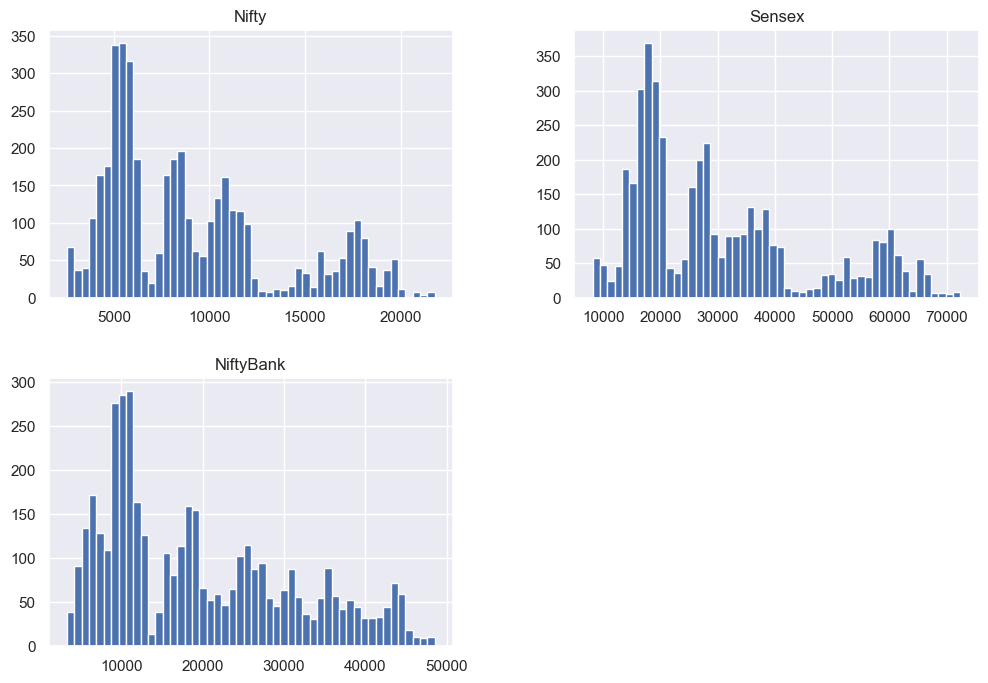

In [29]:
fig = plt.figure()
fig = df.hist(bins=50, figsize=(12, 8))
plt.show()

As we can see, the distribution of the dataframe is very spread out, we need to transform it to make it less skewed and decrease variance.

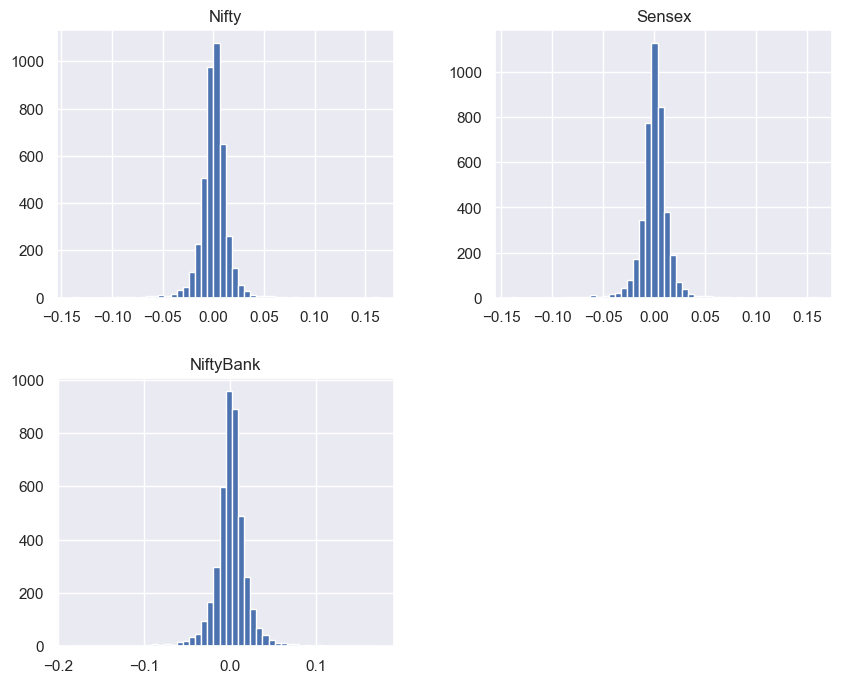

In [30]:
df_log = np.log(df / df.shift(1)).dropna()
df_log.hist(bins=50, figsize=(10, 8))
plt.show()

In [31]:
for i in symbols:
  print([i])
  result = adfuller(df_log[i], autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
  if result[0] < result[4]["5%"]:
      print ("Reject Null Hypothesis. So, Time Series is Stationary")
  else:
      print ("Failed to reject Null Hypothesis. So, Time Series is Non-Stationary")
  print("\n")

['Nifty']
ADF Statistic: -14.053969
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Null Hypothesis. So, Time Series is Stationary


['Sensex']
ADF Statistic: -19.206559
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Null Hypothesis. So, Time Series is Stationary


['NiftyBank']
ADF Statistic: -24.666398
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Null Hypothesis. So, Time Series is Stationary




Transforming the series has made it stationary.

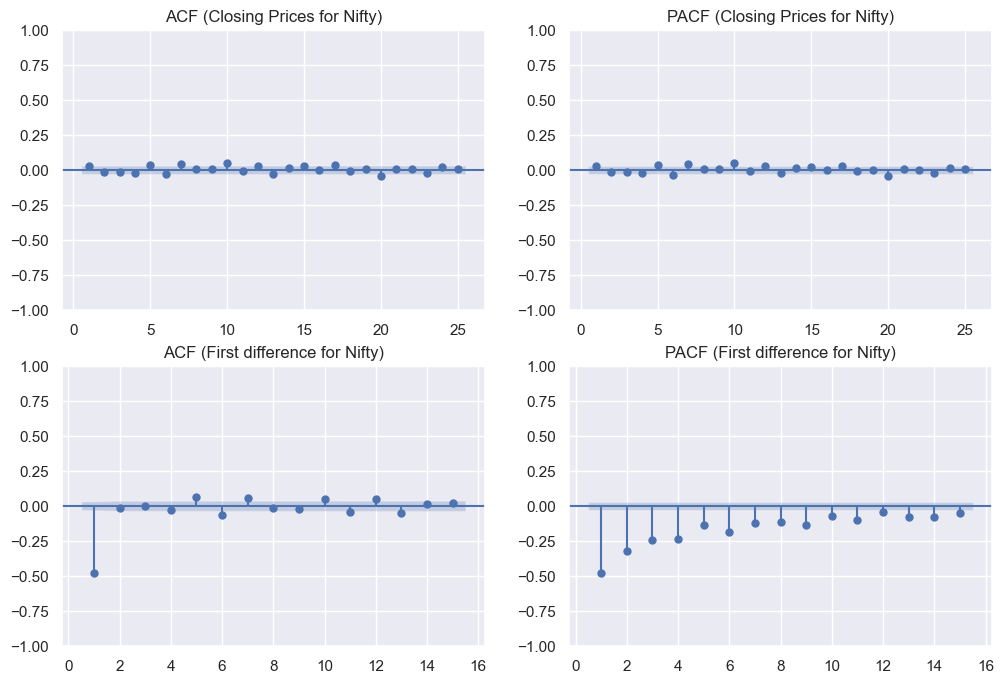

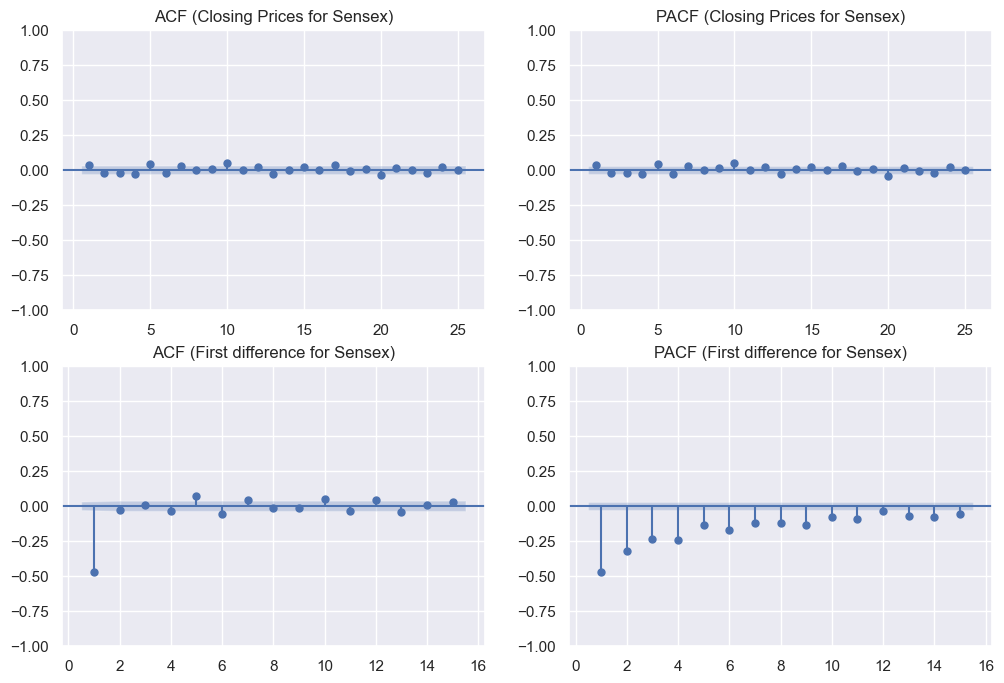

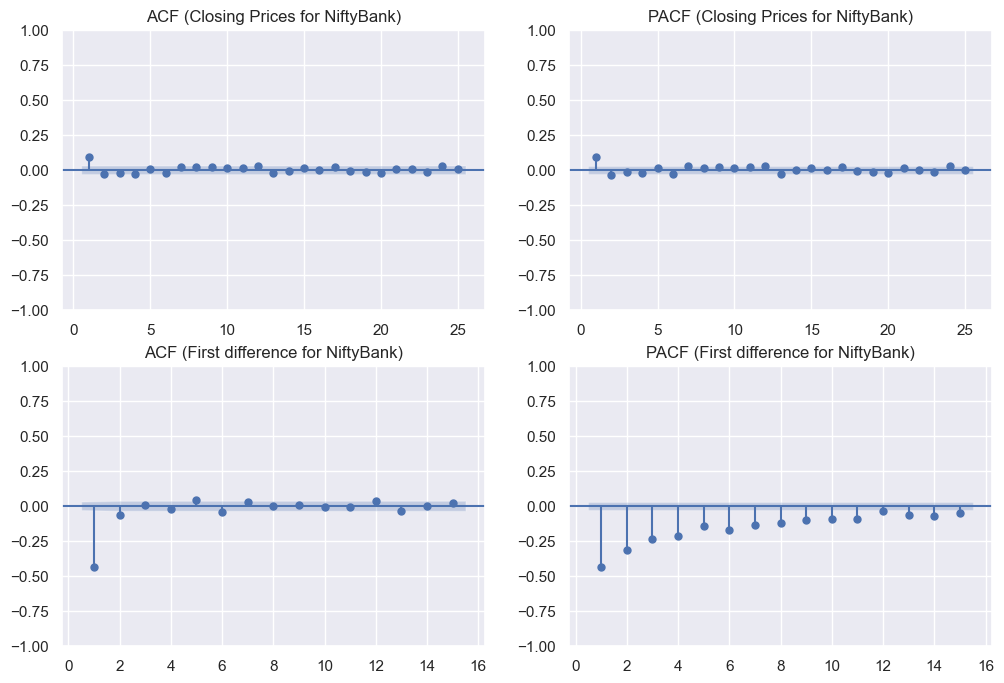

In [32]:
diff_df_log=pd.DataFrame()
for i in symbols:
  diff_df_log[i]=df_log[i].dropna().diff()
  # Plot ACF and PACF for the original series
  plt.figure(figsize=(12, 8))

  plt.subplot(2, 2, 1)
  plot_acf(df_log[i].dropna(), lags=25, ax=plt.gca(), zero=False)
  plt.title(f'ACF (Closing Prices for {i})')

  plt.subplot(2, 2, 2)
  plot_pacf(df_log[i].dropna(), lags=25, ax=plt.gca(), zero=False)
  plt.title(f'PACF (Closing Prices for {i})')

  # Plot ACF and PACF for the differenced series
  plt.subplot(2, 2, 3)
  plot_acf(diff_df_log[i].dropna(), lags=15, ax=plt.gca(), zero=False)
  plt.title(f'ACF (First difference for {i})')

  plt.subplot(2, 2, 4)
  plot_pacf(diff_df_log[i].dropna(), lags=15, ax=plt.gca(), zero=False)
  plt.title(f'PACF (First difference for {i})')

  plt.show()

All 3 indices point towards an ARIMA(0,1,1) process for the transformed data. However, Box-Cox transformation and back transformation is out of scope for this project so we will try to fit the original data into a SARIMA model.

## ARIMA Modelling and Fitting

### For transformed  ARIMA (0,1,1) model

In [33]:
from statsmodels.tsa.arima.model import ARIMA
results={}
for i in symbols:
  # Fit the ARIMA model on the differenced series (AR=1, MA=1)
  model = ARIMA(df_log[i].dropna(), order=(0, 1, 1))
  results[i] = model.fit()

  # Summary of the ARIMA model
  arima_model_summary = results[i].summary()
  print(arima_model_summary)

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Nifty   No. Observations:                 4187
Model:                 ARIMA(0, 1, 1)   Log Likelihood               12070.332
Date:                Mon, 11 Nov 2024   AIC                         -24136.665
Time:                        19:22:51   BIC                         -24123.986
Sample:                             0   HQIC                        -24132.181
                               - 4187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.051    -19.685      0.000      -1.100      -0.900
sigma2         0.0002    9.1e-06     20.070      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   2.64   Jarque-

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Sensex   No. Observations:                 4187
Model:                 ARIMA(0, 1, 1)   Log Likelihood               12051.042
Date:                Mon, 11 Nov 2024   AIC                         -24098.085
Time:                        19:22:55   BIC                         -24085.406
Sample:                             0   HQIC                        -24093.601
                               - 4187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.076    -13.186      0.000      -1.149      -0.851
sigma2         0.0002   1.38e-05     13.368      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   4.34   Jarque-

c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nisha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              NiftyBank   No. Observations:                 4187
Model:                 ARIMA(0, 1, 1)   Log Likelihood               10810.948
Date:                Mon, 11 Nov 2024   AIC                         -21617.896
Time:                        19:23:00   BIC                         -21605.217
Sample:                             0   HQIC                        -21613.412
                               - 4187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.026    -38.669      0.000      -1.051      -0.949
sigma2         0.0003   8.49e-06     39.269      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  35.69   Jarque-

Since p-values for all coefficients are < 0.05, this model is good as the coefficients are statistically significant at 95% confidence levels.





### Diagnostic checking of ARIMA (0,1,1) model

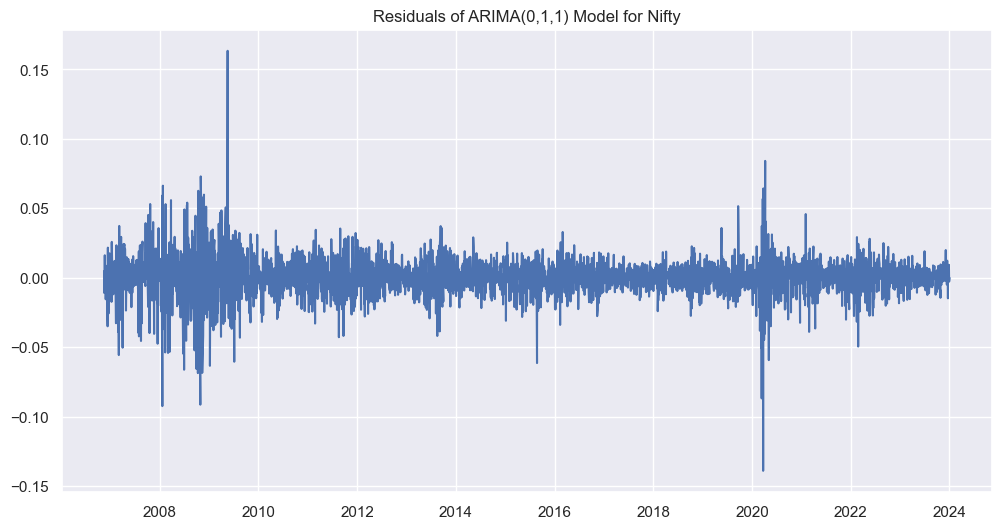

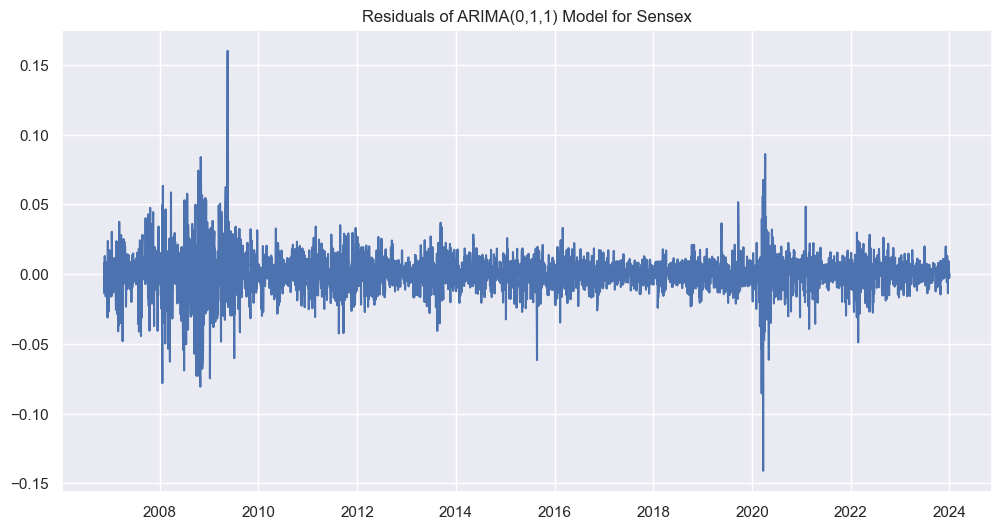

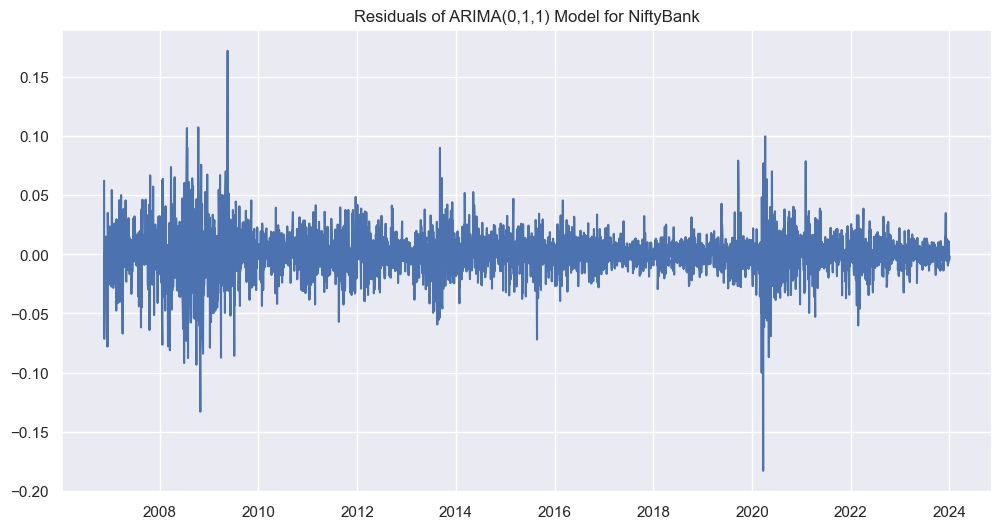

In [34]:
residuals={}
for i in symbols:
  residuals[i] = results[i].resid
  plt.figure(figsize=(12, 6))
  plt.plot(residuals[i])
  plt.title(f'Residuals of ARIMA(0,1,1) Model for {i}')

plt.show()

Note that the residuals for all three have greater values during 2008(Recession) and 2020(COVID), which were troubling times for the world financially.

['Nifty'] 
     lb_stat  lb_pvalue
1      2.65       0.10
2      3.58       0.17
3      5.08       0.17
4      6.86       0.14
5     11.37       0.04
6     15.65       0.02
7     21.79       0.00
8     21.89       0.01
9     22.15       0.01
10    32.19       0.00
['Sensex'] 
     lb_stat  lb_pvalue
1      4.33       0.04
2      6.41       0.04
3      8.30       0.04
4     11.48       0.02
5     18.36       0.00
6     21.30       0.00
7     23.81       0.00
8     23.82       0.00
9     24.16       0.00
10    34.66       0.00
['NiftyBank'] 
     lb_stat  lb_pvalue
1     33.77        0.0
2     36.90        0.0
3     38.94        0.0
4     41.78        0.0
5     42.15        0.0
6     44.77        0.0
7     46.38        0.0
8     47.81        0.0
9     49.44        0.0
10    50.17        0.0


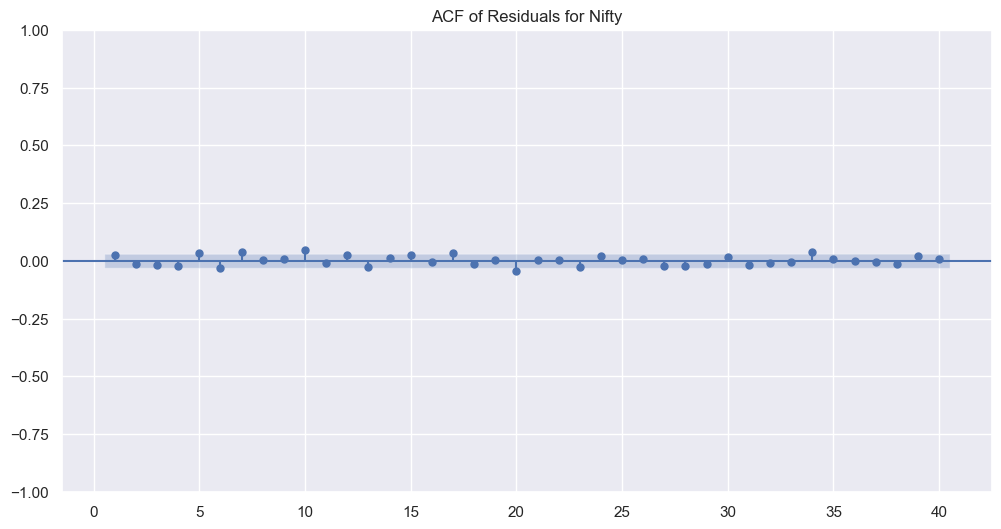

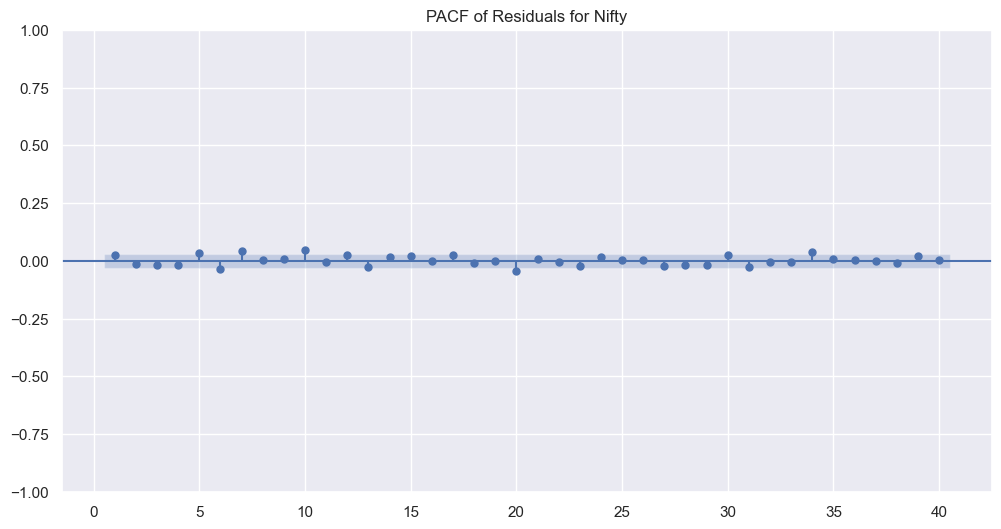

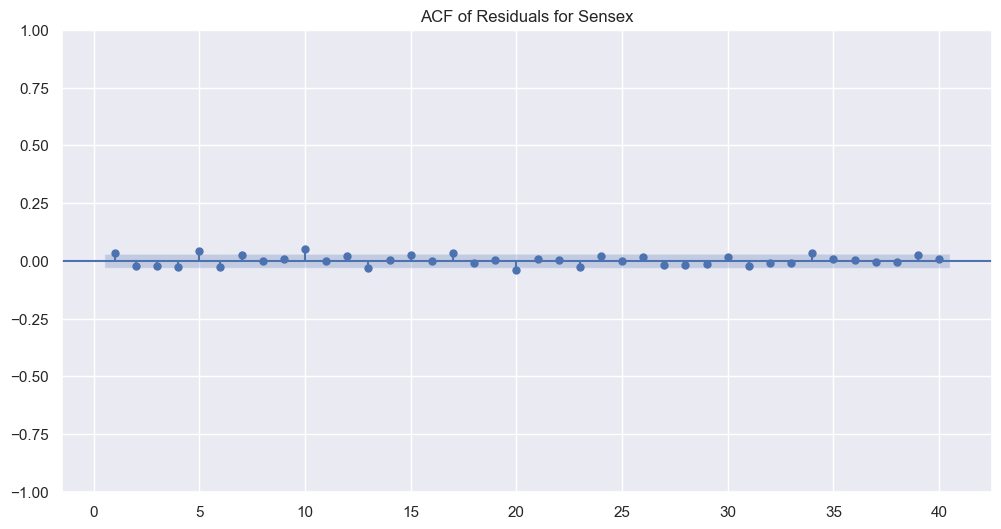

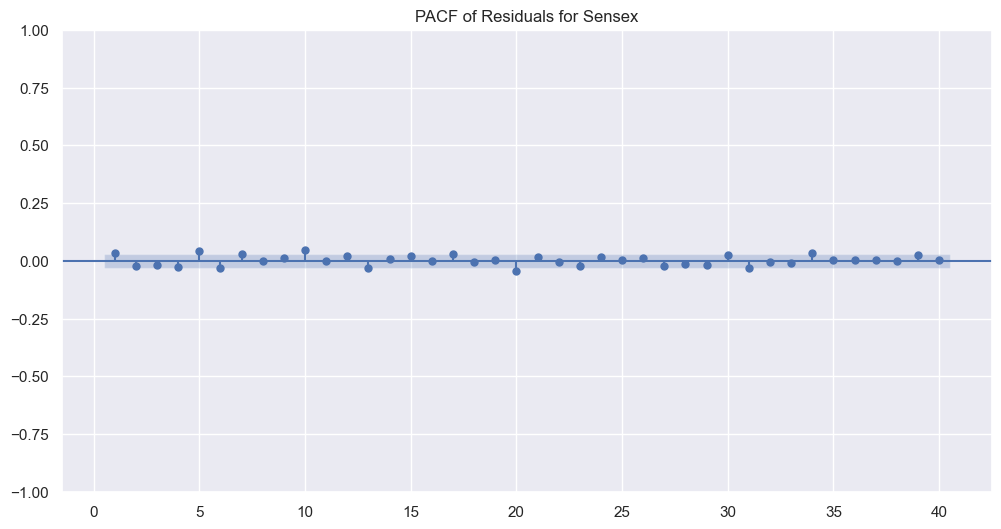

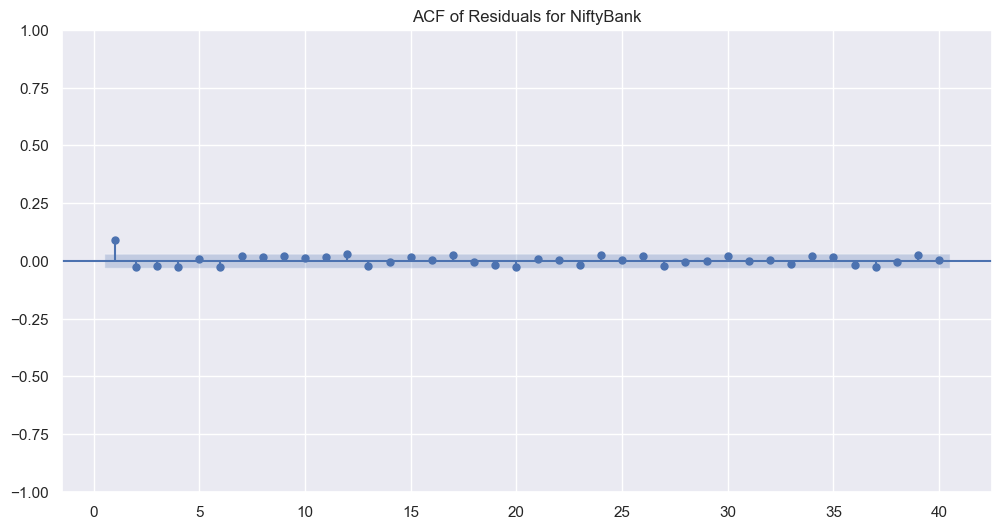

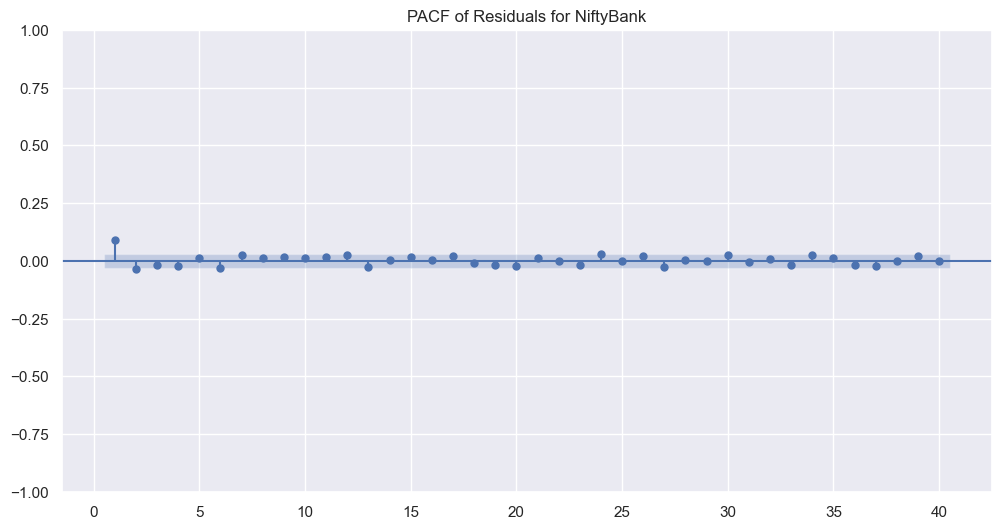

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for i in symbols:
  ljung_box_test = acorr_ljungbox(residuals[i],  return_df=True)
  ljung_box_test=ljung_box_test.round(2)
  print([i],'\n',ljung_box_test)
  # Plot ACF of residuals
  plt.figure(figsize=(12, 6))
  plot_acf(residuals[i], lags=40, ax=plt.gca(), zero=False)
  plt.title(f"ACF of Residuals for {i}")

  # Plot PACF of residuals
  plt.figure(figsize=(12, 6))
  plot_pacf(residuals[i], lags=40, ax=plt.gca(), zero=False)
  plt.title(f"PACF of Residuals for {i}")

plt.show()



Though the ACF and PACF of residuals show barely any correlation for first two indices with a greater correlation at lag 1 for Nifty Bank, the Q statistics imply significant correlation between residuals and this may not be the best model. We will use the auto_arima function now to see best fit.

### Finding best model using auto_arima

In [36]:
!py -m pip install pmdarima


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Checking sarima models for varying values of m and returning best model found at some m for all 3 indices.

In [37]:
from pmdarima import auto_arima

def arima_auto(arr,m):
  finalModel={}
  pred={}
  train_data=pd.DataFrame() # splitting into test and train data
  test_data=pd.DataFrame()
  plt.figure(figsize=(12,8))
  for i, sym in enumerate(symbols): # for all 3 stocks
      print(f'\n{sym} Modelling\n\n')
      # if i!=2:
      #   continue
      models=list()
      for period in m:
        #finding best model by trying out all values of m
        print(f'\n{period} Seasonal period\n\n')
        train_data[sym], test_data[sym] = df[sym][1:int(len(df[sym])*0.8)], df[sym][int(len(df)*0.8):]
        model = auto_arima(train_data[sym], trace=True, m = period,error_action='ignore', suppress_warnings=True)
        models.append((period,model))
      print(models)
      model=min(models,key=lambda p:p[1].aic())
      period=model[0]
      model=model[1]
      print(f'\nChosen {period} as Seasonal period.\n')
      model.fit(train_data[sym]) # fitting the model
      finalModel[sym]=model
      forecast = model.predict(n_periods=len(test_data[sym]))
      forecast=pd.DataFrame(forecast.values,index=test_data.index)
      pred[sym]=forecast
      # forecast = pd.DataFrame(forecast,index = test_data.index) # plot the predictions for validation set
      plt.plot(train_data, label='Train {}'.format(sym))
      plt.plot(test_data, label='Test {}'.format(sym))
      plt.plot(forecast, label='Prediction {}'.format(sym))
  plt.title('Stocks Price Prediction\n')
  plt.xlabel('Date')
  plt.ylabel('Actual Stock Price')
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())
  plt.show()
  return finalModel,pred,train_data,test_data

In [ ]:
df=df.dropna()
# print(df.info())
# df.isnull().sum()
models,predictions,train,test=arima_auto(df,[1,4,12])



Nifty Modelling



1 Seasonal period


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39540.800, Time=83.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39582.172, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39583.928, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39583.943, Time=2.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39582.219, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39583.619, Time=16.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39585.058, Time=1.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=39588.830, Time=8.54 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=39521.235, Time=37.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=39586.943, Time=11.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=39522.337, Time=36.12 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=39518.450, Time=22.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=39572.146, Time=24.85 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : A

All 3 models have chosen m=1 for best fit. As we can see, the predicted values dont seem to capture non linearity in data well. We will extract residuals from training set and train our LSTM to forecast residuals. Upon adding these to our forecast from ARIMA, we will obtain a better fit hopefully.

###Calculating mse

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for sym in predictions:
  mse = mean_squared_error(test[sym], predictions[sym])
  print(f'Mean Squared Error (MSE) for {sym} Forecast: {mse}')

###Diagnostic Checking


In [ ]:
residuals={}
for sym in models:
  residuals[sym]=models[sym].resid()
  plt.figure(figsize=(12, 6))
  plt.plot(residuals[sym])
  plt.title(f'Residuals of Model for {sym}')

plt.show()



In [ ]:
for sym in models:
  print(models[sym].summary())

In [ ]:

for i in symbols:
  ljung_box_test = acorr_ljungbox(residuals[i],  return_df=True)
  ljung_box_test=ljung_box_test.round(2)
  print([i],'\n',ljung_box_test)
  # Plot ACF of residuals
  plt.figure(figsize=(12, 6))
  plot_acf(residuals[i], lags=40, ax=plt.gca(), zero=False)
  plt.title(f"ACF of Residuals for {i}")

  # Plot PACF of residuals
  plt.figure(figsize=(12, 6))
  plot_pacf(residuals[i], lags=40, ax=plt.gca(), zero=False)
  plt.title(f"PACF of Residuals for {i}")

plt.show()



The ACF, PACF and Q stats for Nifty and Sensex point towards residuals being random white noise, proving that there is no autocorrelation among residuals and model is a decent fit. For NiftyBank, there appears to be some correlation after 5 lags.